<a href="https://colab.research.google.com/github/RicardoMourao-py/CNN-ALZHEIMER-CLASSIFICATION/blob/main/main_oasis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import auth
# from google.cloud import storage
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# !unzip data_slices/VeryMildDemented.zip
# !unzip data_slices/NonDemented.zip

In [ ]:
folder = './data_slices/'
folder_path = pathlib.Path(folder)

## Visualizando Imagem

<PIL.Image.Image image mode=RGB size=459x543 at 0x7D599D741450>


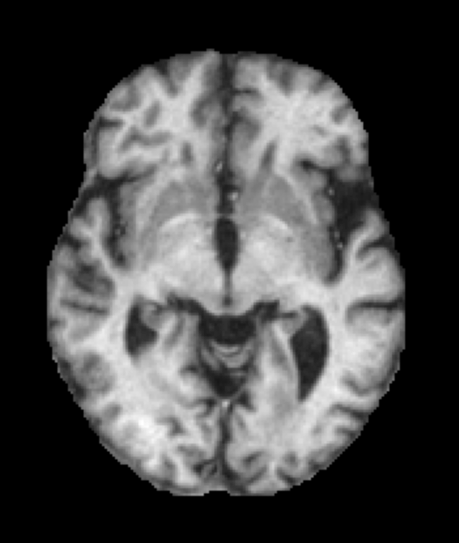

In [ ]:
photo = load_img('./data_slices/MildDemented/0028_70.png')
print(photo)
photo

## Imagens e suas Classificações

In [ ]:
for file in listdir(folder):
    print(file)

NonDemented.zip
NonDemented
MildDemented
.ipynb_checkpoints
ModerateDemented
VeryMildDemented


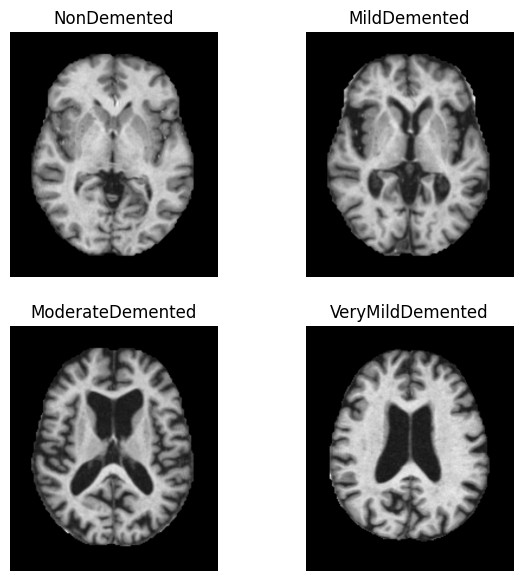

In [ ]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder+'/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(file)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [ ]:
# counting the number of images in each category
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        i = i +1
    print(file , i)

NonDemented 4860
MildDemented 1008
.ipynb_checkpoints 0
ModerateDemented 72
VeryMildDemented 2520


## Image Generator

In [ ]:
# Criando o gerador de dados de imagem para ter mais amostras

IMG_SIZE = 128                  # tamanho da imagem de saída após o pré-processamento e aumento de dados
DIM = (IMG_SIZE, IMG_SIZE)      # tupla que especifica as dimensões da imagem de saída

ZOOM = [.99, 1.01]              # zoom que será aplicada às imagens
BRIGHT_RANGE = [0.8, 1.2]       #  ajuste de brilho
HORZ_FLIP = True                # espelhamento horizontal
FILL_MODE = "constant"          # pixels adicionados durante o redimensionamento serão preenchidos com um valor constante
DATA_FORMAT = "channels_last"   # formato dos dados é (altura, largura, canais)

In [ ]:
# Gerador de dados de treinamento com aumento de dados e suas normalizações
train_generator = ImageDataGenerator(
                                      rescale = 1./255,
                                      brightness_range=BRIGHT_RANGE,
                                      zoom_range=ZOOM,
                                      data_format=DATA_FORMAT,
                                      fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP
                                    )

train_data_gen = train_generator.flow_from_directory(
                                                      directory=folder,
                                                      target_size=DIM,
                                                      batch_size=6500,
                                                      shuffle=False
                                                    )

Found 8460 images belonging to 5 classes.


In [ ]:
CLASSES = list(train_data_gen.class_indices.keys())

# def show_images(generator,y_pred=None):
#     # get image lables
#     labels =dict(zip([0,1,2,3], CLASSES))

#     # get a batch of images
#     x,y = generator.next()

#     # display a grid of 9 images
#     plt.figure(figsize=(7, 7))
#     if y_pred is None:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             idx = randint(0, 6400)
#             plt.imshow(x[idx])
#             plt.axis("off")
#             plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
#     else:
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(x[i])
#             plt.axis("off")
#             plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# # Display Train Images
# show_images(train_data_gen)

In [ ]:
# retorna o próximo lote de dados e suas respectivas etiquetas.
train_data, train_labels = train_data_gen.next()

In [ ]:
train_data.shape, train_labels.shape

((6500, 128, 128, 3), (6500, 5))

In [ ]:
# O SMOTE é uma técnica comumente usada para lidar com conjuntos de dados de classificação que
# têm classes minoritárias com menos exemplos do que as classes majoritárias.
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(19440, 49152) (19440, 4)


In [ ]:
# alterar as dimensões de um array sem alterar os dados em si
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(19440, 128, 128, 3) (19440, 4)


In [ ]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
# Defining convolutional blocks
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())

    return block

In [ ]:
# defining dense blocks
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [ ]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [ ]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')
    ], name = "cnn_model")

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

In [ ]:
plot_model(model)

NameError: name 'model' is not defined

In [ ]:
CALLBACKS = [
    EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]

In [ ]:
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=CALLBACKS)

Epoch 1/50
389/389 [==============================] - ETA: 0s - loss: 1.5141 - acc: 0.3551 - auc: 0.6216 - f1_score: 0.3516

389/389 [==============================] - 42s 48ms/step - loss: 1.5141 - acc: 0.3551 - auc: 0.6216 - f1_score: 0.3516 - val_loss: 3.1597 - val_acc: 0.2510 - val_auc: 0.5114 - val_f1_score: 0.1004
Epoch 2/50
388/389 [============================>.] - ETA: 0s - loss: 0.9114 - acc: 0.5859 - auc: 0.8492 - f1_score: 0.5798

389/389 [==============================] - 15s 38ms/step - loss: 0.9114 - acc: 0.5857 - auc: 0.8492 - f1_score: 0.5796 - val_loss: 5.5413 - val_acc: 0.2739 - val_auc: 0.5450 - val_f1_score: 0.1291
Epoch 3/50
389/389 [==============================] - ETA: 0s - loss: 0.6753 - acc: 0.7114 - auc: 0.9186 - f1_score: 0.7088

389/389 [==============================] - 16s 41ms/step - loss: 0.6753 - acc: 0.7114 - auc: 0.9186 - f1_score: 0.7088 - val_loss: 0.9243 - val_acc: 0.6062 - val_auc: 0.8923 - val_f1_score: 0.5696
Epoch 4/50
389/389 [==============================] - ETA: 0s - loss: 0.5222 - acc: 0.7929 - auc: 0.9516 - f1_score: 0.7916

389/389 [==============================] - 15s 38ms/step - loss: 0.5222 - acc: 0.7929 - auc: 0.9516 - f1_score: 0.7916 - val_loss: 1.4697 - val_acc: 0.5995 - val_auc: 0.8327 - val_f1_score: 0.5588
Epoch 5/50
389/389 [==============================] - ETA: 0s - loss: 0.4033 - acc: 0.8438 - auc: 0.9706 - f1_score: 0.8433

389/389 [==============================] - 15s 38ms/step - loss: 0.4033 - acc: 0.8438 - auc: 0.9706 - f1_score: 0.8433 - val_loss: 0.6922 - val_acc: 0.7596 - val_auc: 0.9395 - val_f1_score: 0.7278
Epoch 6/50
389/389 [==============================] - ETA: 0s - loss: 0.3269 - acc: 0.8765 - auc: 0.9801 - f1_score: 0.8762

389/389 [==============================] - 16s 40ms/step - loss: 0.3269 - acc: 0.8765 - auc: 0.9801 - f1_score: 0.8762 - val_loss: 0.9975 - val_acc: 0.6978 - val_auc: 0.9185 - val_f1_score: 0.6367
Epoch 7/50
389/389 [==============================] - ETA: 0s - loss: 0.2568 - acc: 0.9068 - auc: 0.9874 - f1_score: 0.9066

389/389 [==============================] - 16s 40ms/step - loss: 0.2568 - acc: 0.9068 - auc: 0.9874 - f1_score: 0.9066 - val_loss: 0.4943 - val_acc: 0.8026 - val_auc: 0.9657 - val_f1_score: 0.7932
Epoch 8/50
389/389 [==============================] - ETA: 0s - loss: 0.2339 - acc: 0.9168 - auc: 0.9888 - f1_score: 0.9167

389/389 [==============================] - 15s 39ms/step - loss: 0.2339 - acc: 0.9168 - auc: 0.9888 - f1_score: 0.9167 - val_loss: 0.3763 - val_acc: 0.8631 - val_auc: 0.9772 - val_f1_score: 0.8586
Epoch 9/50
388/389 [============================>.] - ETA: 0s - loss: 0.1823 - acc: 0.9347 - auc: 0.9931 - f1_score: 0.9347

389/389 [==============================] - 15s 39ms/step - loss: 0.1822 - acc: 0.9347 - auc: 0.9931 - f1_score: 0.9347 - val_loss: 0.6901 - val_acc: 0.7473 - val_auc: 0.9349 - val_f1_score: 0.7460
Epoch 10/50
389/389 [==============================] - ETA: 0s - loss: 0.1507 - acc: 0.9474 - auc: 0.9950 - f1_score: 0.9474

389/389 [==============================] - 16s 40ms/step - loss: 0.1507 - acc: 0.9474 - auc: 0.9950 - f1_score: 0.9474 - val_loss: 0.2374 - val_acc: 0.9222 - val_auc: 0.9906 - val_f1_score: 0.9194
Epoch 11/50
389/389 [==============================] - ETA: 0s - loss: 0.1336 - acc: 0.9544 - auc: 0.9960 - f1_score: 0.9545

389/389 [==============================] - 15s 38ms/step - loss: 0.1336 - acc: 0.9544 - auc: 0.9960 - f1_score: 0.9545 - val_loss: 0.3885 - val_acc: 0.8833 - val_auc: 0.9776 - val_f1_score: 0.8762
Epoch 12/50
389/389 [==============================] - ETA: 0s - loss: 0.1091 - acc: 0.9642 - auc: 0.9969 - f1_score: 0.9642

389/389 [==============================] - 15s 40ms/step - loss: 0.1091 - acc: 0.9642 - auc: 0.9969 - f1_score: 0.9642 - val_loss: 0.1118 - val_acc: 0.9614 - val_auc: 0.9964 - val_f1_score: 0.9614
Epoch 13/50
389/389 [==============================] - ETA: 0s - loss: 0.1195 - acc: 0.9602 - auc: 0.9964 - f1_score: 0.9603

389/389 [==============================] - 16s 40ms/step - loss: 0.1195 - acc: 0.9602 - auc: 0.9964 - f1_score: 0.9603 - val_loss: 0.6984 - val_acc: 0.7782 - val_auc: 0.9493 - val_f1_score: 0.7627
Epoch 14/50
388/389 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9658 - auc: 0.9973 - f1_score: 0.9658

389/389 [==============================] - 15s 40ms/step - loss: 0.1014 - acc: 0.9658 - auc: 0.9973 - f1_score: 0.9659 - val_loss: 2.0117 - val_acc: 0.4998 - val_auc: 0.7669 - val_f1_score: 0.5013
Epoch 15/50
389/389 [==============================] - ETA: 0s - loss: 0.0991 - acc: 0.9669 - auc: 0.9974 - f1_score: 0.9669

389/389 [==============================] - 17s 44ms/step - loss: 0.0991 - acc: 0.9669 - auc: 0.9974 - f1_score: 0.9669 - val_loss: 0.1341 - val_acc: 0.9585 - val_auc: 0.9954 - val_f1_score: 0.9581
Epoch 16/50
389/389 [==============================] - ETA: 0s - loss: 0.0824 - acc: 0.9741 - auc: 0.9978 - f1_score: 0.9742

389/389 [==============================] - 15s 39ms/step - loss: 0.0824 - acc: 0.9741 - auc: 0.9978 - f1_score: 0.9742 - val_loss: 0.2254 - val_acc: 0.9238 - val_auc: 0.9918 - val_f1_score: 0.9225
Epoch 17/50
389/389 [==============================] - ETA: 0s - loss: 0.0833 - acc: 0.9740 - auc: 0.9977 - f1_score: 0.9741

389/389 [==============================] - 16s 40ms/step - loss: 0.0833 - acc: 0.9740 - auc: 0.9977 - f1_score: 0.9741 - val_loss: 0.3606 - val_acc: 0.8865 - val_auc: 0.9808 - val_f1_score: 0.8771
Epoch 18/50
388/389 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.9798 - auc: 0.9986 - f1_score: 0.9798

389/389 [==============================] - 15s 39ms/step - loss: 0.0656 - acc: 0.9797 - auc: 0.9986 - f1_score: 0.9798 - val_loss: 0.0998 - val_acc: 0.9682 - val_auc: 0.9974 - val_f1_score: 0.9678
Epoch 19/50
389/389 [==============================] - ETA: 0s - loss: 0.0676 - acc: 0.9789 - auc: 0.9983 - f1_score: 0.9790

389/389 [==============================] - 15s 39ms/step - loss: 0.0676 - acc: 0.9789 - auc: 0.9983 - f1_score: 0.9790 - val_loss: 0.1239 - val_acc: 0.9589 - val_auc: 0.9963 - val_f1_score: 0.9585
Epoch 20/50
389/389 [==============================] - ETA: 0s - loss: 0.0629 - acc: 0.9789 - auc: 0.9986 - f1_score: 0.9790

389/389 [==============================] - 15s 39ms/step - loss: 0.0629 - acc: 0.9789 - auc: 0.9986 - f1_score: 0.9790 - val_loss: 0.0997 - val_acc: 0.9682 - val_auc: 0.9961 - val_f1_score: 0.9680
Epoch 21/50
389/389 [==============================] - ETA: 0s - loss: 0.0473 - acc: 0.9856 - auc: 0.9990 - f1_score: 0.9856

389/389 [==============================] - 16s 40ms/step - loss: 0.0473 - acc: 0.9856 - auc: 0.9990 - f1_score: 0.9856 - val_loss: 0.0365 - val_acc: 0.9875 - val_auc: 0.9995 - val_f1_score: 0.9874
Epoch 22/50
388/389 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9831 - auc: 0.9985 - f1_score: 0.9831

389/389 [==============================] - 16s 40ms/step - loss: 0.0539 - acc: 0.9831 - auc: 0.9985 - f1_score: 0.9831 - val_loss: 0.1342 - val_acc: 0.9589 - val_auc: 0.9955 - val_f1_score: 0.9583
Epoch 23/50
388/389 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9821 - auc: 0.9985 - f1_score: 0.9822

389/389 [==============================] - 17s 42ms/step - loss: 0.0596 - acc: 0.9821 - auc: 0.9985 - f1_score: 0.9821 - val_loss: 0.5833 - val_acc: 0.8290 - val_auc: 0.9576 - val_f1_score: 0.8379
Epoch 24/50
389/389 [==============================] - ETA: 0s - loss: 0.0461 - acc: 0.9840 - auc: 0.9992 - f1_score: 0.9840

389/389 [==============================] - 15s 39ms/step - loss: 0.0461 - acc: 0.9840 - auc: 0.9992 - f1_score: 0.9840 - val_loss: 0.0851 - val_acc: 0.9717 - val_auc: 0.9985 - val_f1_score: 0.9714
Epoch 25/50
389/389 [==============================] - ETA: 0s - loss: 0.0518 - acc: 0.9839 - auc: 0.9988 - f1_score: 0.9840

389/389 [==============================] - 16s 40ms/step - loss: 0.0518 - acc: 0.9839 - auc: 0.9988 - f1_score: 0.9840 - val_loss: 0.1461 - val_acc: 0.9550 - val_auc: 0.9950 - val_f1_score: 0.9542
Epoch 26/50
389/389 [==============================] - ETA: 0s - loss: 0.0356 - acc: 0.9891 - auc: 0.9994 - f1_score: 0.9891

389/389 [==============================] - 15s 39ms/step - loss: 0.0356 - acc: 0.9891 - auc: 0.9994 - f1_score: 0.9891 - val_loss: 0.7338 - val_acc: 0.8287 - val_auc: 0.9472 - val_f1_score: 0.8272
Epoch 27/50
389/389 [==============================] - ETA: 0s - loss: 0.0429 - acc: 0.9872 - auc: 0.9989 - f1_score: 0.9872

389/389 [==============================] - 16s 40ms/step - loss: 0.0429 - acc: 0.9872 - auc: 0.9989 - f1_score: 0.9872 - val_loss: 0.1441 - val_acc: 0.9614 - val_auc: 0.9930 - val_f1_score: 0.9614
Epoch 28/50
388/389 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9853 - auc: 0.9991 - f1_score: 0.9854

389/389 [==============================] - 15s 39ms/step - loss: 0.0474 - acc: 0.9852 - auc: 0.9991 - f1_score: 0.9852 - val_loss: 0.0903 - val_acc: 0.9736 - val_auc: 0.9972 - val_f1_score: 0.9733
Epoch 29/50
389/389 [==============================] - ETA: 0s - loss: 0.0335 - acc: 0.9900 - auc: 0.9992 - f1_score: 0.9900

389/389 [==============================] - 15s 39ms/step - loss: 0.0335 - acc: 0.9900 - auc: 0.9992 - f1_score: 0.9900 - val_loss: 0.0445 - val_acc: 0.9881 - val_auc: 0.9987 - val_f1_score: 0.9879
Epoch 30/50
389/389 [==============================] - ETA: 0s - loss: 0.0359 - acc: 0.9890 - auc: 0.9993 - f1_score: 0.9890

389/389 [==============================] - 16s 40ms/step - loss: 0.0359 - acc: 0.9890 - auc: 0.9993 - f1_score: 0.9890 - val_loss: 0.1339 - val_acc: 0.9611 - val_auc: 0.9950 - val_f1_score: 0.9611
Epoch 31/50
389/389 [==============================] - ETA: 0s - loss: 0.0430 - acc: 0.9871 - auc: 0.9992 - f1_score: 0.9872

389/389 [==============================] - 15s 39ms/step - loss: 0.0430 - acc: 0.9871 - auc: 0.9992 - f1_score: 0.9872 - val_loss: 0.0581 - val_acc: 0.9826 - val_auc: 0.9988 - val_f1_score: 0.9824
Epoch 32/50
389/389 [==============================] - ETA: 0s - loss: 0.0251 - acc: 0.9920 - auc: 0.9996 - f1_score: 0.9920

389/389 [==============================] - 15s 39ms/step - loss: 0.0251 - acc: 0.9920 - auc: 0.9996 - f1_score: 0.9920 - val_loss: 0.1208 - val_acc: 0.9637 - val_auc: 0.9954 - val_f1_score: 0.9627
Epoch 33/50
389/389 [==============================] - ETA: 0s - loss: 0.0347 - acc: 0.9895 - auc: 0.9992 - f1_score: 0.9895

389/389 [==============================] - 16s 40ms/step - loss: 0.0347 - acc: 0.9895 - auc: 0.9992 - f1_score: 0.9895 - val_loss: 0.0440 - val_acc: 0.9862 - val_auc: 0.9991 - val_f1_score: 0.9861
Epoch 34/50
389/389 [==============================] - ETA: 0s - loss: 0.0276 - acc: 0.9917 - auc: 0.9994 - f1_score: 0.9917

389/389 [==============================] - 16s 40ms/step - loss: 0.0276 - acc: 0.9917 - auc: 0.9994 - f1_score: 0.9917 - val_loss: 0.1637 - val_acc: 0.9521 - val_auc: 0.9926 - val_f1_score: 0.9514
Epoch 35/50
389/389 [==============================] - ETA: 0s - loss: 0.0305 - acc: 0.9896 - auc: 0.9993 - f1_score: 0.9896

389/389 [==============================] - 16s 40ms/step - loss: 0.0305 - acc: 0.9896 - auc: 0.9993 - f1_score: 0.9896 - val_loss: 0.2707 - val_acc: 0.9245 - val_auc: 0.9869 - val_f1_score: 0.9224
Epoch 36/50
389/389 [==============================] - ETA: 0s - loss: 0.0295 - acc: 0.9924 - auc: 0.9992 - f1_score: 0.9924

389/389 [==============================] - 17s 43ms/step - loss: 0.0295 - acc: 0.9924 - auc: 0.9992 - f1_score: 0.9924 - val_loss: 0.0344 - val_acc: 0.9897 - val_auc: 0.9988 - val_f1_score: 0.9896
Epoch 37/50
389/389 [==============================] - ETA: 0s - loss: 0.0188 - acc: 0.9943 - auc: 0.9997 - f1_score: 0.9943

389/389 [==============================] - 17s 43ms/step - loss: 0.0188 - acc: 0.9943 - auc: 0.9997 - f1_score: 0.9943 - val_loss: 0.5806 - val_acc: 0.8631 - val_auc: 0.9606 - val_f1_score: 0.8633
Epoch 38/50
389/389 [==============================] - ETA: 0s - loss: 0.0336 - acc: 0.9896 - auc: 0.9992 - f1_score: 0.9896

389/389 [==============================] - 16s 40ms/step - loss: 0.0336 - acc: 0.9896 - auc: 0.9992 - f1_score: 0.9896 - val_loss: 0.0627 - val_acc: 0.9769 - val_auc: 0.9987 - val_f1_score: 0.9767
Epoch 39/50
389/389 [==============================] - ETA: 0s - loss: 0.0181 - acc: 0.9943 - auc: 0.9997 - f1_score: 0.9943

389/389 [==============================] - 16s 40ms/step - loss: 0.0181 - acc: 0.9943 - auc: 0.9997 - f1_score: 0.9943 - val_loss: 0.0615 - val_acc: 0.9801 - val_auc: 0.9984 - val_f1_score: 0.9801
Epoch 40/50
389/389 [==============================] - ETA: 0s - loss: 0.0306 - acc: 0.9903 - auc: 0.9994 - f1_score: 0.9903

389/389 [==============================] - 15s 39ms/step - loss: 0.0306 - acc: 0.9903 - auc: 0.9994 - f1_score: 0.9903 - val_loss: 0.0522 - val_acc: 0.9839 - val_auc: 0.9981 - val_f1_score: 0.9838
Epoch 41/50
388/389 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9936 - auc: 0.9995 - f1_score: 0.9936

389/389 [==============================] - 15s 39ms/step - loss: 0.0219 - acc: 0.9936 - auc: 0.9996 - f1_score: 0.9936 - val_loss: 0.0805 - val_acc: 0.9775 - val_auc: 0.9971 - val_f1_score: 0.9772
Epoch 42/50
389/389 [==============================] - ETA: 0s - loss: 0.0121 - acc: 0.9969 - auc: 0.9997 - f1_score: 0.9970

389/389 [==============================] - 15s 39ms/step - loss: 0.0121 - acc: 0.9969 - auc: 0.9997 - f1_score: 0.9970 - val_loss: 0.0579 - val_acc: 0.9852 - val_auc: 0.9970 - val_f1_score: 0.9852
Epoch 43/50
389/389 [==============================] - ETA: 0s - loss: 0.0224 - acc: 0.9932 - auc: 0.9994 - f1_score: 0.9933

389/389 [==============================] - 16s 40ms/step - loss: 0.0224 - acc: 0.9932 - auc: 0.9994 - f1_score: 0.9933 - val_loss: 0.5734 - val_acc: 0.8833 - val_auc: 0.9595 - val_f1_score: 0.8776
Epoch 44/50
389/389 [==============================] - ETA: 0s - loss: 0.0298 - acc: 0.9916 - auc: 0.9992 - f1_score: 0.9916

389/389 [==============================] - 15s 39ms/step - loss: 0.0298 - acc: 0.9916 - auc: 0.9992 - f1_score: 0.9916 - val_loss: 0.2205 - val_acc: 0.9412 - val_auc: 0.9897 - val_f1_score: 0.9384
Epoch 45/50
389/389 [==============================] - ETA: 0s - loss: 0.0186 - acc: 0.9946 - auc: 0.9995 - f1_score: 0.9946

389/389 [==============================] - 15s 39ms/step - loss: 0.0186 - acc: 0.9946 - auc: 0.9995 - f1_score: 0.9946 - val_loss: 0.0538 - val_acc: 0.9849 - val_auc: 0.9982 - val_f1_score: 0.9847
Epoch 46/50
389/389 [==============================] - ETA: 0s - loss: 0.0145 - acc: 0.9953 - auc: 0.9999 - f1_score: 0.9953

389/389 [==============================] - 16s 41ms/step - loss: 0.0145 - acc: 0.9953 - auc: 0.9999 - f1_score: 0.9953 - val_loss: 0.1736 - val_acc: 0.9540 - val_auc: 0.9920 - val_f1_score: 0.9534
Epoch 47/50
389/389 [==============================] - ETA: 0s - loss: 0.0283 - acc: 0.9912 - auc: 0.9993 - f1_score: 0.9912

389/389 [==============================] - 16s 40ms/step - loss: 0.0283 - acc: 0.9912 - auc: 0.9993 - f1_score: 0.9912 - val_loss: 0.4163 - val_acc: 0.9087 - val_auc: 0.9731 - val_f1_score: 0.9061
Epoch 48/50
389/389 [==============================] - ETA: 0s - loss: 0.0139 - acc: 0.9967 - auc: 0.9997 - f1_score: 0.9967

389/389 [==============================] - 15s 39ms/step - loss: 0.0139 - acc: 0.9967 - auc: 0.9997 - f1_score: 0.9967 - val_loss: 0.1597 - val_acc: 0.9569 - val_auc: 0.9928 - val_f1_score: 0.9564
Epoch 49/50
389/389 [==============================] - ETA: 0s - loss: 0.0663 - acc: 0.9800 - auc: 0.9981 - f1_score: 0.9800

389/389 [==============================] - 15s 39ms/step - loss: 0.0663 - acc: 0.9800 - auc: 0.9981 - f1_score: 0.9800 - val_loss: 0.0437 - val_acc: 0.9865 - val_auc: 0.9987 - val_f1_score: 0.9864
Epoch 50/50
389/389 [==============================] - ETA: 0s - loss: 0.0104 - acc: 0.9969 - auc: 0.9999 - f1_score: 0.9969

389/389 [==============================] - 15s 40ms/step - loss: 0.0104 - acc: 0.9969 - auc: 0.9999 - f1_score: 0.9969 - val_loss: 0.0493 - val_acc: 0.9855 - val_auc: 0.9979 - val_f1_score: 0.9855


In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

122/122 [==============================] - 2s 15ms/step - loss: 0.0683 - acc: 0.9841 - auc: 0.9962 - f1_score: 0.9841
Testing Accuracy: 98.41%


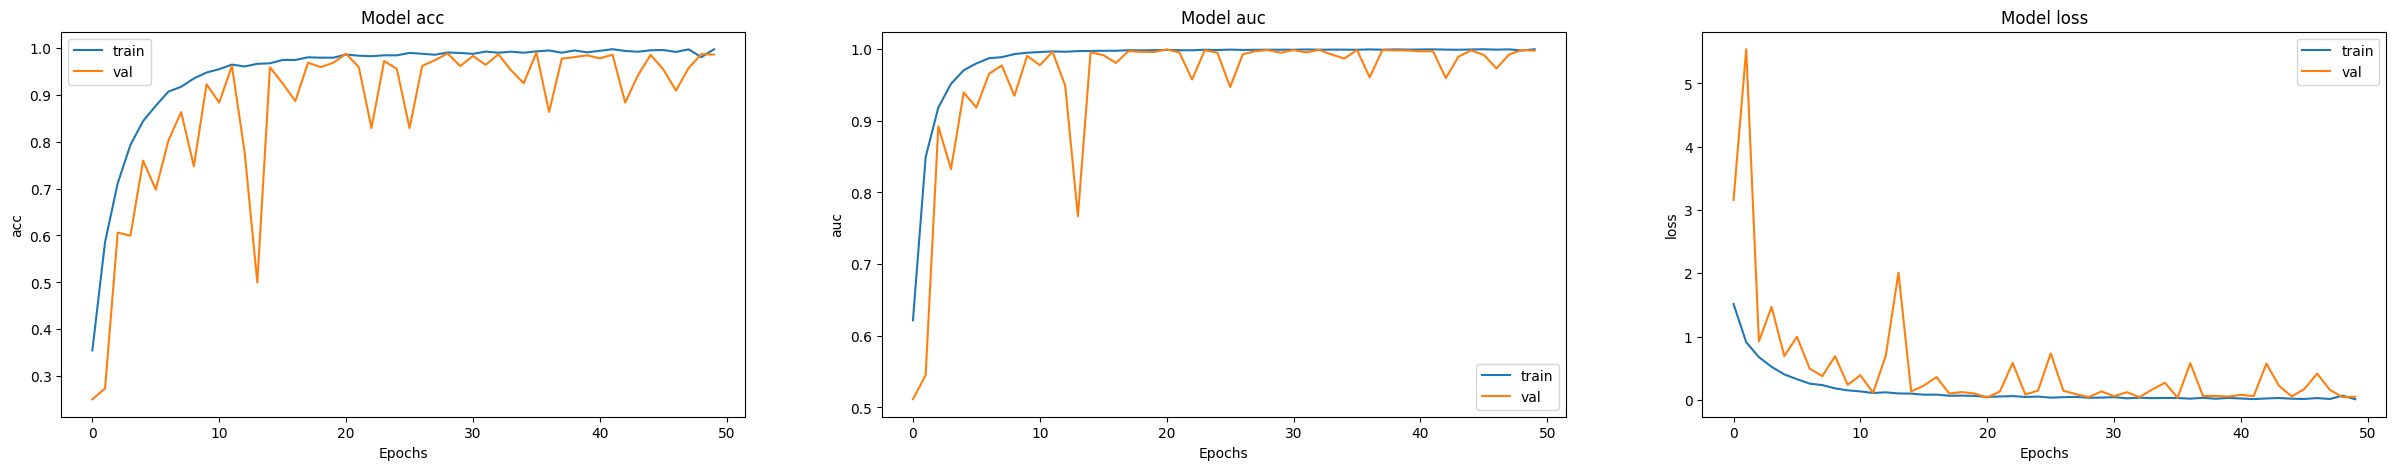

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

122/122 [==============================] - 1s 8ms/step


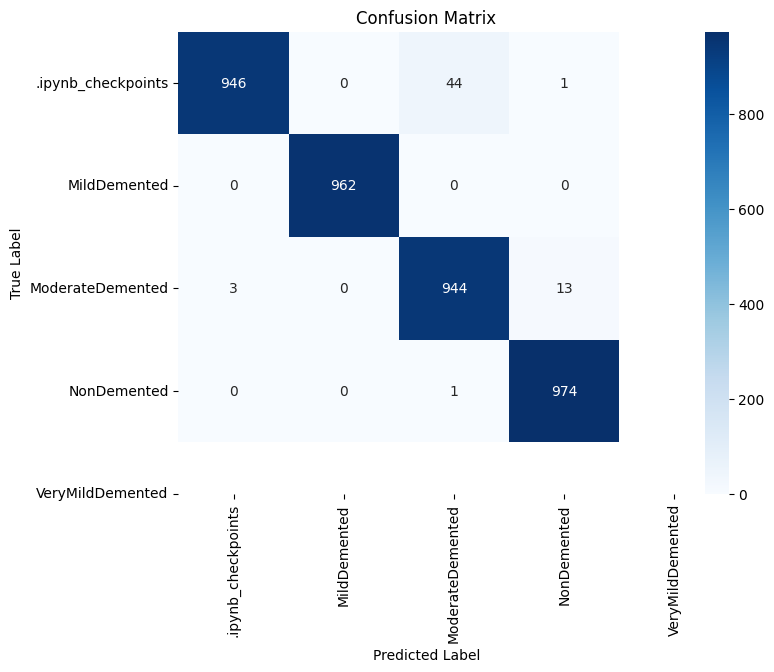

In [ ]:
# Convertendo as previsões para classes
test_predictions = model.predict(test_data)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(test_true_classes, test_predictions_classes)

# Plotando a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculando métricas
accuracy = accuracy_score(test_true_classes, test_predictions_classes)
precision = precision_score(test_true_classes, test_predictions_classes, average='weighted')
recall = recall_score(test_true_classes, test_predictions_classes, average='weighted')
f1 = f1_score(test_true_classes, test_predictions_classes, average='weighted')

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade:", recall)
print("F1-Score:", f1)

Acurácia: 0.9840534979423868
Precisão: 0.984406109529151
Sensibilidade: 0.9840534979423868
F1-Score: 0.9840493579522556


In [ ]:
inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 dropout_5 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_99 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 512)       

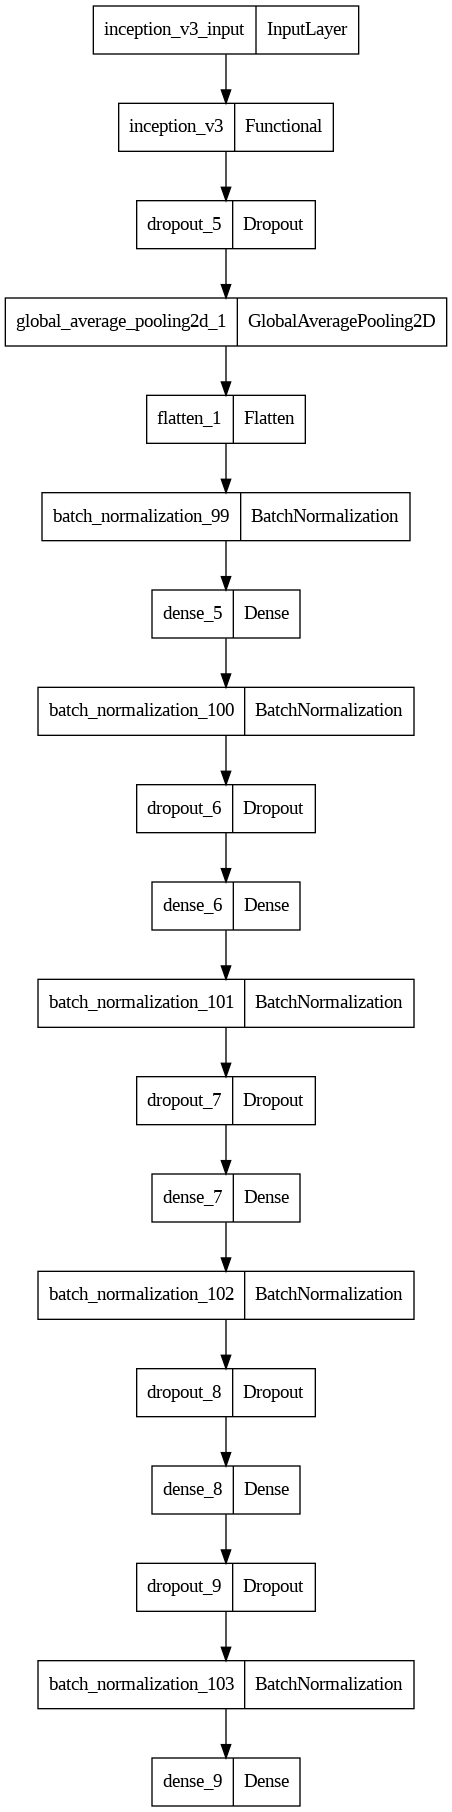

In [ ]:
plot_model(inception_model)

In [ ]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [ ]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

Epoch 1/50
389/389 [==============================] - 35s 54ms/step - loss: 1.2291 - acc: 0.4589 - auc: 0.7371 - f1_score: 0.4542 - val_loss: 0.7200 - val_acc: 0.6731 - val_auc: 0.9046 - val_f1_score: 0.6567
Epoch 2/50
389/389 [==============================] - 15s 38ms/step - loss: 0.8274 - acc: 0.6360 - auc: 0.8777 - f1_score: 0.6313 - val_loss: 0.5607 - val_acc: 0.7621 - val_auc: 0.9458 - val_f1_score: 0.7515
Epoch 3/50
389/389 [==============================] - 15s 39ms/step - loss: 0.7072 - acc: 0.7041 - auc: 0.9123 - f1_score: 0.7025 - val_loss: 0.4615 - val_acc: 0.8049 - val_auc: 0.9654 - val_f1_score: 0.7998
Epoch 4/50
389/389 [==============================] - 15s 37ms/step - loss: 0.6229 - acc: 0.7500 - auc: 0.9325 - f1_score: 0.7496 - val_loss: 0.3838 - val_acc: 0.8547 - val_auc: 0.9761 - val_f1_score: 0.8517
Epoch 5/50
389/389 [==============================] - 15s 38ms/step - loss: 0.5693 - acc: 0.7838 - auc: 0.9439 - f1_score: 0.7835 - val_loss: 0.3441 - val_acc: 0.8650 -

In [ ]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

122/122 [==============================] - 5s 38ms/step - loss: 0.1363 - acc: 0.9529 - auc: 0.9955 - f1_score: 0.9528
Testing Accuracy: 95.29%


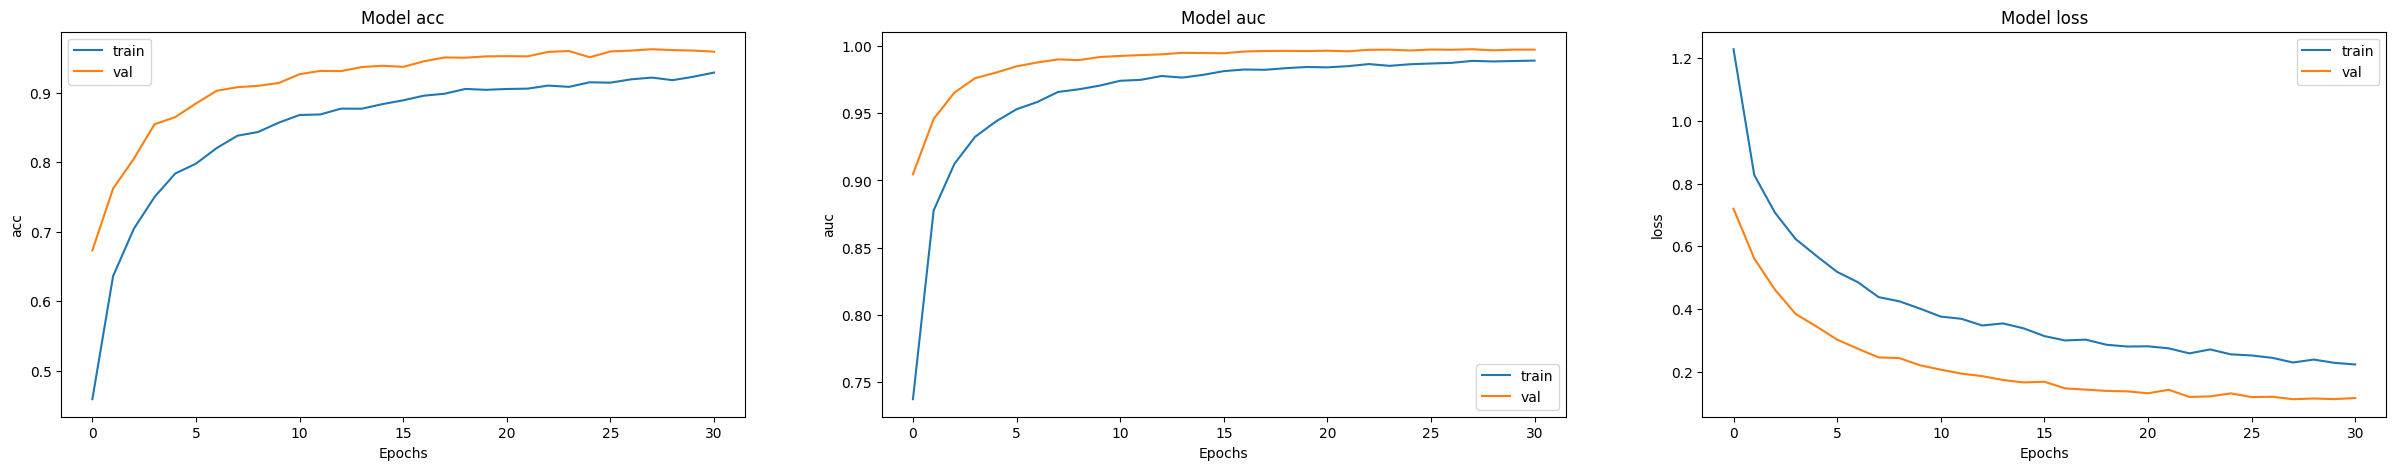

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

122/122 [==============================] - 3s 23ms/step


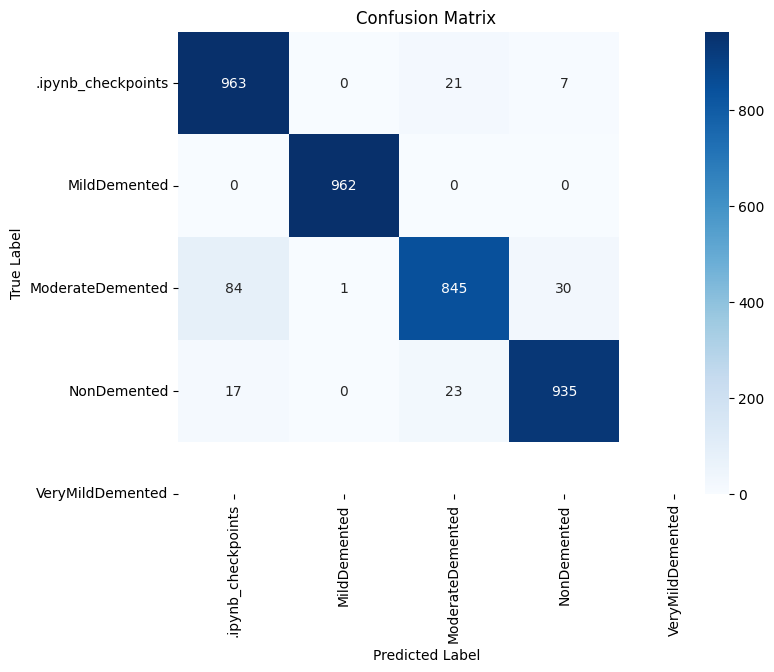

In [ ]:
# Convertendo as previsões para classes
test_predictions = inception_model.predict(test_data)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(test_true_classes, test_predictions_classes)

# Plotando a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculando métricas
accuracy = accuracy_score(test_true_classes, test_predictions_classes)
precision = precision_score(test_true_classes, test_predictions_classes, average='weighted')
recall = recall_score(test_true_classes, test_predictions_classes, average='weighted')
f1 = f1_score(test_true_classes, test_predictions_classes, average='weighted')

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Sensibilidade:", recall)
print("F1-Score:", f1)

Acurácia: 0.9529320987654321
Precisão: 0.9537814535562046
Sensibilidade: 0.9529320987654321
F1-Score: 0.952721051279891


In [ ]:
# entender o que ta colaborando, quais fatias sao usadas na classificação, shap
# o que que é um unidade que ele classifica, o que é uma linha do dataset uma fatia?
# verificar dados

In [ ]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import numpy as np
import shap
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# set batch size
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
# set transformation for training and validation
transform_train = transforms.Compose([
                transforms.Resize(size = (224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5946, 0.5732, 0.5126), std=(0.2671, 0.2737, 0.3058)) # use calculated mean and std
                ])

# # define data loader
# train_loader = torch.utils.data.DataLoader(train_data,
#                                            batch_size=TRAIN_BATCH_SIZE,
#                                            shuffle=True,
#                                            num_workers=4)
# test_loader = torch.utils.data.DataLoader(test_data,
#                                           batch_size=VAL_BATCH_SIZE,
#                                           shuffle=False,
#                                           num_workers=4)

# set transformation for SHAP visualization
base_transform = transforms.Compose([
                 transforms.Resize(size = (224, 224)),
                 transforms.ToTensor()
                 ])
# set dataset
base_dataset = datasets.ImageFolder("./dataset", transform=base_transform)
# define data loader
base_loader = torch.utils.data.DataLoader(base_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
batch = next(iter(base_loader))
images, labels = batch

background = images[:61].to(device)
test_images = images[61:64].to(device)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [ ]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

AttributeError: ignored